## Beat tracking demo from librosa http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display

In [30]:
# Load audio
filename='kingsLoop.wav'
y, sr = librosa.load(filename)

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Harmonic-percussive source separation
y_harmonic, y_percussive = librosa.effects.hpss(y)

# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

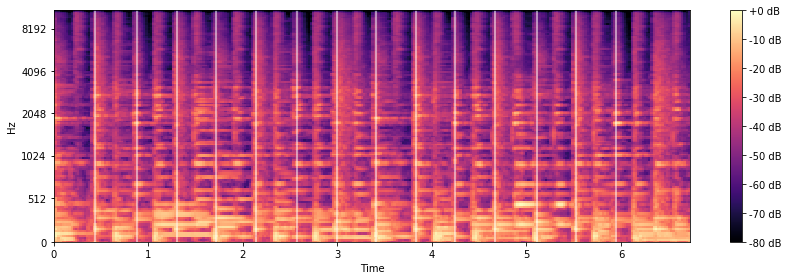

In [3]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

In [4]:
# By default, the beat tracker will trim away any leading or trailing beats that don't appear strong enough.
# To disable this behavior, call beat_track() with trim=False.

print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        143.55 BPM
First 5 beat frames:    [19 38 56 74 92]
First 5 beat times:     [0.44117914 0.88235828 1.30031746 1.71827664 2.13623583]


## Beat-synchronous feature aggregation
Once we've located the beat events, we can use them to summarize the feature content of each beat.

This can be useful for reducing data dimensionality, and removing transient noise from the features.

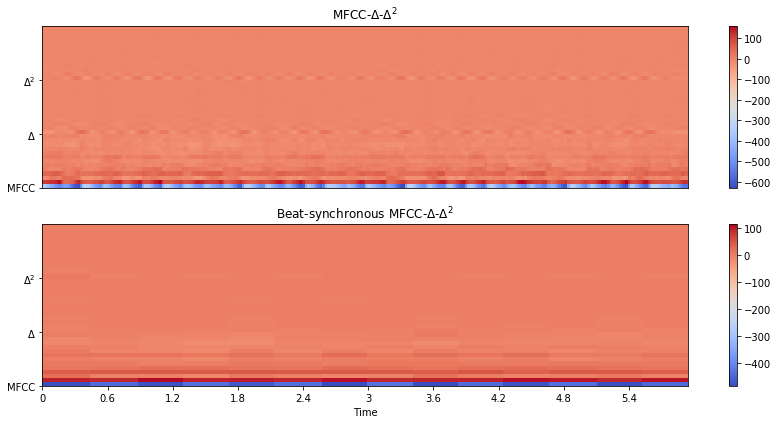

In [5]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

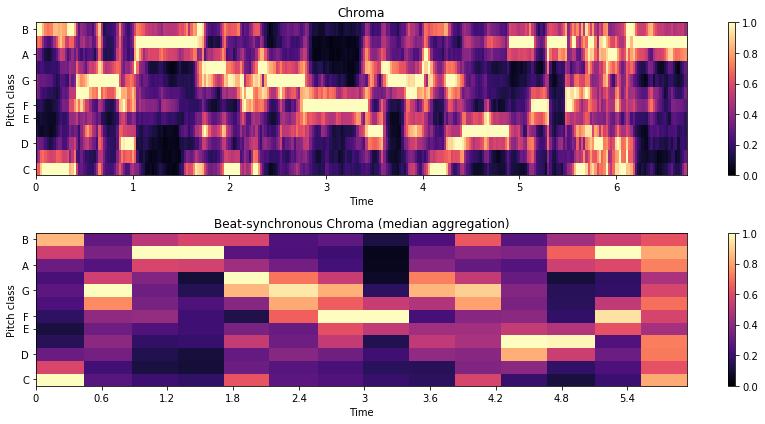

In [6]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()

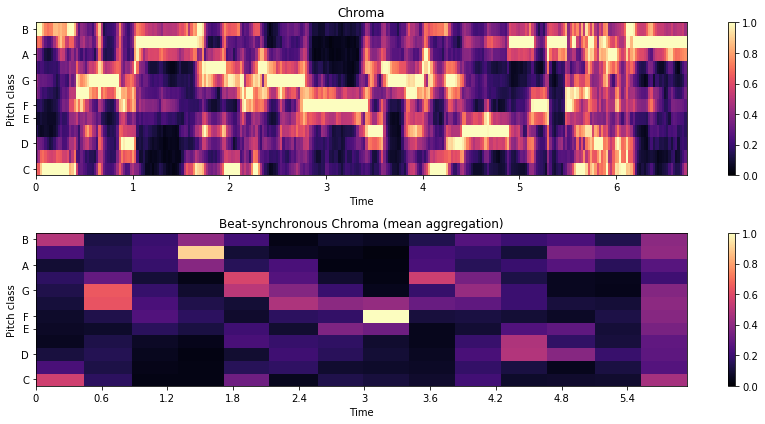

In [37]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.min)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (min aggregation)')

plt.colorbar()
plt.tight_layout()

In [7]:
samp = np.zeros(len(y))
sampLoc=librosa.frames_to_samples(beats)
samp[sampLoc]=1
IPython.display.Audio(data=samp, rate=sr)

In [8]:
IPython.display.Audio(data=y, rate=sr)

In [9]:
newSig=np.zeros((len(y),2))
newSig[:,0]=samp
newSig[:,1]=y*0.1
meanNewSig=np.mean(newSig,1)
IPython.display.Audio(data=meanNewSig, rate=sr)

# Create a function to return the beat times and tempo estimates

In [10]:
# %load beatTrackingFunction
#!/usr/bin/env python3
"""
Created on Tue Nov 27 12:30:06 2018

@author: jcdevaney
"""

import librosa

def beatTrack(filename):
    
    # Load audio
    y, sr = librosa.load(filename)
            
    # Harmonic-percussive source separation
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    # Now, let's run the beat tracker.
    # We'll use the percussive component for this part
    tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
        
    beatTimes = librosa.frames_to_time(beats)
    
    return tempo, beats, beatTimes

In [11]:
tempo, beats, beatTimes=beatTrack('kingsLoop.wav')

In [5]:
beatTimes

array([0.44117914, 0.88235828, 1.30031746, 1.71827664, 2.13623583,
       2.57741497, 2.99537415, 3.41333333, 3.83129252, 4.2492517 ,
       4.66721088, 5.10839002, 5.52634921, 5.94430839])

In [6]:
tempo

143.5546875

In [7]:
(beatTimes[1]-beatTimes[0])/4+beatTimes[0]

0.5514739229024943

In [8]:
beats

array([ 19,  38,  56,  74,  92, 111, 129, 147, 165, 183, 201, 220, 238,
       256])

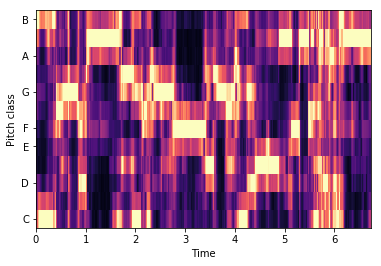

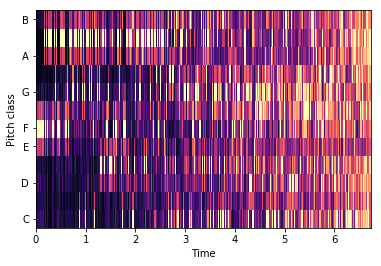

array([136, 135, 140, 137, 139, 132, 134, 231, 133,  62, 141,  63,  60,
        61, 138, 125,  59, 161, 280, 131, 142, 271,  64, 230,  54,  58,
       126, 160, 124, 278, 281, 279, 159,  52,  65, 270, 162,  53,   6,
       286,  32,  55,  33,   5,  51, 232, 158,  57, 105, 272, 130,   7,
       269,  34,  50, 106, 208, 207, 277, 197, 285, 224, 128,  31, 209,
       206, 213, 225, 198, 129, 143,  56, 104, 287, 196,   4, 123, 127,
       212, 217, 205,  68, 233,  49,   8, 204, 107, 234, 268, 276, 163,
       214, 282, 284, 195,  66, 199, 218, 235,  35, 216,  47, 223,  69,
        80,  48, 226, 275, 157, 229, 288, 144, 203,  30, 215,   3,  79,
         9,  78,  81,  67, 194,   1, 180, 103, 289, 283, 273, 181, 111,
       211,  25, 112, 179,   0, 178, 122, 202,  26, 108, 156, 113, 145,
         2, 151,  46, 152, 267,  77,  70, 193,  13, 210,  19,  10, 110,
       115, 274,  89, 150,  88,  94,  14, 192, 177, 114,  95,  12,  82,
       219, 227, 164, 146, 102, 153,  24,  27, 222, 200,  93,  2